In [329]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import time
time_start_global = time.time()

# Monte Carlo-simulering av polymerfolding

##### En introduksjon

Simulering var en av de første oppgavene som ble gitt til datamaskiner når de først ble oppfunnet, de har blitt brukt til å simulere ting som krigføring, været og vitenskapelige fenomener og beregninger. Målet for denne koden er å simulere bretting av polymerer som består av sammenhengende kjeder av monomerer. 

Polymerfysikk er læren om polymerer og deres mekaniske egenskaper, og gjennom denne rapporten skal det bli sett nærmere på simulering av polymerer og deres vekselvirkninger. For å få til numeriske tilnærminger av polymerer blir det tatt i bruk numeriske metoder og simuleringer som tar utganspunkt i den virkelige verden, hvor Monte Carlo simuleringer blir sett ekstra nærme på.

## Oppgave 1 - Grunnleggende polymer-funksjonalitet


#### 1 a)

##### Numerisk representasjon av polymer

For å representere en polymer av en gitt lengde numerisk er det mulig å lagre hele gitteret, inkludert alle null-elementene, som en matrise, hvor sidelengdene er større enn polymeret. Dette er derimot ikke hensiktsmessig ettersom majoriteten av informasjonen lagret er overflødig. For å forenkle dette kan istedet kun selve posisjonen av hver monomer lagres. Polymeren representeres i et 2D kartesisk kordinatsystem, og dermed kan hver monomer posisjon beskrives av en tuppel med kordinatene x og y. Slik kan hele polymeren være representert av en N x 2 matrise, dette resulterer i en O(N) lagringskompleksitet.   

#### 1 b)

In [330]:
def polymer_array(N: int) -> list[int]:
   """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
   return [(i, 0) for i in range(-N//2, N//2)]

#### 1 c)

Energien til en gitt polymer er avhengig av antall monomerer som vekselsvirker med hverandre. Reglene for denne vekselvirkningen er oppgitt i seksjon 2 av prosjektheftet. I algoritme 1 og 2, som begge er Monte Carlo-metoder, velges tilfeldig en monomer som roteres om. Velges en endemonomer som rotasjonspunkt vil hele polymeret roteres 90 grader i rommet, men ingenting mer. Ettersom rotasjon i endemonomerene ikke endrer formen av polymeret, det vil si at antall monomerer som vekselsvirker med hverandre vil forbli likt, vil det heller ikke oppstå noen endring av energien i polymeret. Dermed er det ikke hensiktsmessig å inkludere endemonomerene i utvalget den tilfeldige monomeren trekkes fra. 

#### 1 d)

In [331]:
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer on a black background,
    with a color gradient going from white at the beginning to purple at the end of the polymer.
    :param polymer_list: list[int]
    :return: None
    """
    # Determine the maximum absolute values of x and y to ensure a square grid
    max_x = max(abs(x) for _, x in polymer_list)
    max_y = max(abs(y) for y, _ in polymer_list)
    max_extent = max(max_x, max_y)

    # Define square grid size based on the maximum extent
    grid_size = 2 * max_extent + 1

    X, Y = np.meshgrid(range(-max_extent, max_extent + 1), range(-max_extent, max_extent + 1))
    Z = np.zeros(X.shape)  # Background initialized to 0 (black)

    # Map intensity values for the polymer: 0 (background) remains black,
    # Intensity for polymer starts from a small positive value towards 1
    for i, (y, x) in enumerate(polymer_list):
        # Map intensity from a range that starts slightly above 0 to ensure visibility against black
        intensity = (i / (len(polymer_list) - 1)) * 0.99 + 0.01  # Avoids pure black for the first monomer
        adjusted_x = x + max_extent
        adjusted_y = y + max_extent
        Z[adjusted_y, adjusted_x] = intensity

    # Define a colormap: starts with black (for 0 intensity), transitions from white to purple
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "white", "purple"])

    plt.figure(figsize=(6,6))  # Adjust figure size as needed
    plt.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')  # 'auto' shading for smooth transition
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  # Optional: Hide axes for a cleaner visualization
    plt.show()

#legger den med nå siden den gjør oppgave 1g) lettere å visualisere

def display_polymer_side_by_side(polymer_list1: list[int], polymer_list2: list[int], name1: [str], name2: [str]) -> None:
    """
    Rewrote the display_polymer function to display two polymers side by side to increase readability.

    In order to simpliefy the automatic grid sizing a subfunction for this purpose is an easy solution
    :param polymer_list1: list[int]
    :param polymer_list2: list[int]
    :param name1: [str]
    :param name2: [str]
    """
    def plot_polymer(ax, polymer_list):
        max_x = max(abs(x) for _, x in polymer_list)
        max_y = max(abs(y) for y, _ in polymer_list)
        max_extent = max(max_x, max_y)

        grid_size = 2 * max_extent + 1

        X, Y = np.meshgrid(range(-max_extent, max_extent + 1), range(-max_extent, max_extent + 1))
        Z = np.zeros(X.shape)

        for i, (y, x) in enumerate(polymer_list):
            intensity = (i / (len(polymer_list) - 1)) * 0.99 + 0.01
            adjusted_x = x + max_extent
            adjusted_y = y + max_extent
            Z[adjusted_y, adjusted_x] = intensity

        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "white", "purple"])

        ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
        ax.set_aspect('equal', adjustable='box')
        ax.axis('off')

    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first polymer on the left subplot
    plot_polymer(axes[0], polymer_list1)
    axes[0].set_title(name1)

    # Display the second polymer on the right subplot
    plot_polymer(axes[1], polymer_list2)
    axes[1].set_title(name2)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

    


#### 1 e)

##### Simulering - en tilnærming av virkeligheten

Når en skal se nærmere på simuleringer så er det hensiktsmessig å definere hvilke regler som gjelder inni den simulerte verden, dette fører til en mer nøyaktig representasjon av virkeligheten. Disse reglene definerer oftest et miljø, samt hvordan det simulerte objektet kan samhandle med miljøet. Dette gjør at simuleringene gir oss resultater som kan ha betydning for videre arbeid. I første omgang defineres lovene for samhandling.

In [332]:

def is_intact_polymer_array(polymer_object: list[int], N: int) -> bool:
    """
    Function that checks if the polymer is intact
    :param polymer_object: list[int]
    :param N: int
    :return: bool
    """
    # convert from numpy array to list
    polymer_object = list(polymer_object)

    # Check if the polymer is the right length
    if len(polymer_object) != N:
        return False

    # Go through each monomer and check if it has a neighbor
    for i in range(N):
        # Hvis det ikke er den første monomeren, sjekk forrige nabo
        if i > 0 and not (abs(polymer_object[i][0] - polymer_object[i-1][0]) == 1 and polymer_object[i][1] == polymer_object[i-1][1]) and not (polymer_object[i][0] == polymer_object[i-1][0] and abs(polymer_object[i][1] - polymer_object[i-1][1]) == 1):
            return False
        
        # If it is not the last monomer, check next neighbor
        if i < N - 1 and not (abs(polymer_object[i][0] - polymer_object[i+1][0]) == 1 and polymer_object[i][1] == polymer_object[i+1][1]) and not (polymer_object[i][0] == polymer_object[i+1][0] and abs(polymer_object[i][1] - polymer_object[i+1][1]) == 1):
            return False
        
        # Check if the monomer is on top of another monomer\n",
        if polymer_object.count(polymer_object[i]) > 1:
            return False
    return True

For implementasjonen av en funksjon som forteller om en polymer er intakt ble krav nummer 2 tolket til å bestemme at ingen monomer kan ha samme koordinater, og ble implementert etter denne tolkningen på bunnen av funksjonen.

#### 1f)

Som nevnt tidligere, så er det hensiktsmessig å definere regler for miljø og samhandling for simuleringer, her defineres hvordan den simulerte agenten kan bevege seg og dermed samhandle med miljøet (som i dette tilfellet vil være et 2D plan).

In [333]:
def rotate_polymer_array(polymer_object: list[int], xy_val: tuple[int, int], counter_clockwise: bool) -> list[int]:
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: list[int]
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: list[int]
    """
    rotated_polymer = []
    rotation_index = polymer_object.index(xy_val)

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for x, y in polymer_to_rotate:
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        rotated_polymer.extend(polymer_remaining)
    else:
        rotated_polymer = polymer_remaining + rotated_polymer

    return rotated_polymer

#### 1g)

In [334]:

def algorithm1_array(N: int, Ns: int) -> (list[int], int):
    """
    function uses algorithm 1 and returns a rotated polymer and the count of succsesful rotations
    :param N: int
    :param Ns: int
    :return: list[int], int
    """
    counter = 0
    polymer_object = polymer_array(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer_array(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer_array(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter

In [370]:
polymer_4, _ = algorithm1_array(15, 4) # creates polymer with N_s = 4
polymer_1000, _ = algorithm1_array(15, 1000) # creates polymer with N_s = 1000
np.savez("polymer.npz", polymer1 = polymer_4, polymer2 = polymer_1000) # saves the two polymers for later use

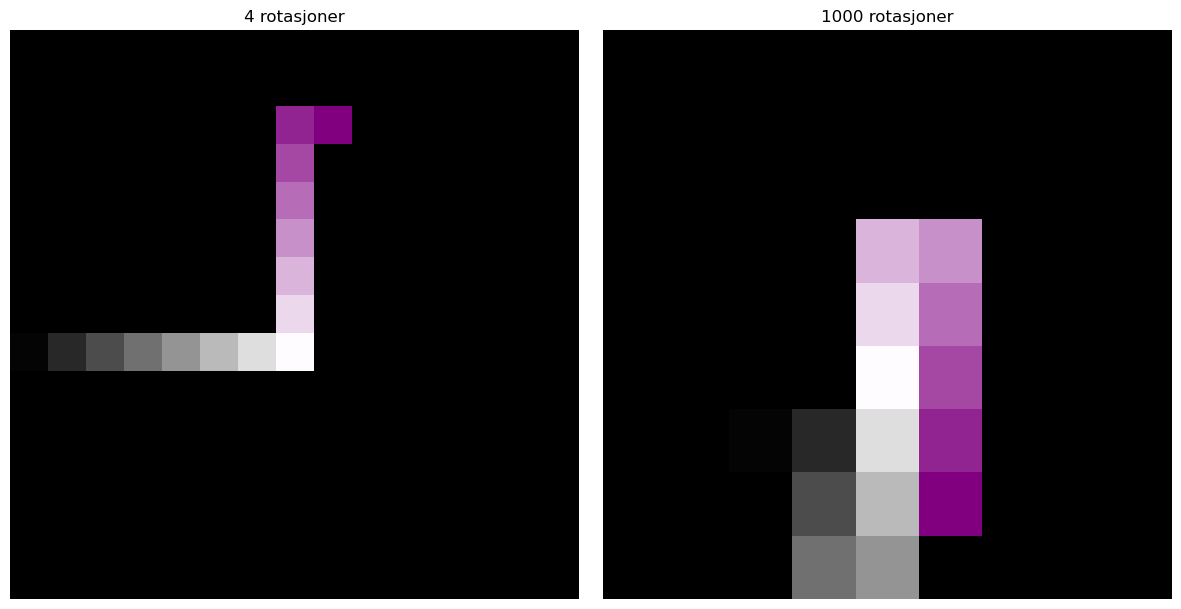

In [371]:
polymerene = np.load("polymer.npz")
polymer_4_load = polymerene["polymer1"]
polymer_1000_load = polymerene["polymer2"]

display_polymer_side_by_side(polymer_4_load, polymer_1000_load, "4 rotasjoner", "1000 rotasjoner") #plots the two polymers side by side

Som en ser vil polymeret med 4 rotasjoner være mindre komplekst, altså gjennomført færre rotasjoner enn polymeret som har gjennomgått 1000 forsøkte rotasjoner. Sluttposisjonen vil selvsagt varriere, men ved få unntak vil polymeret med N_s satt til 1000 være mer kompakt enn polymeret med N_s satt til 4

#### 1h)

##### Optimalisering av kjøretid

Så langt har implementasjoen av Polymer holdt til små tilfeller, kjøretid har ikke vært et av stor praktisk eller økonomisk interesse. Hvis en skal kjøre mange simuleringer derimot, vil det være mer hensiktsmessig å implementere en effektiv og økonomisk implementasjon som kan skaleres til mange simuleringer uten at kjøretiden øker betydelig mer enn kjøretiden. Derfor ble metodene bearbeidet til å kjøre så optimalt som mulig.

In [337]:
# implementasjon med numpy array
def create_polymer(N: int) -> np.ndarray:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return np.array([(i, 0) for i in range(-N//2, N//2)])

def is_intact_polymer_np(polymer_object: np.ndarray, N: int) -> bool:
    """
    Function that checks if the polymer is intact for a NumPy array implementation.
    :param polymer_object: NumPy array of shape (N, 2), representing N monomers' coordinates.
    :param N: int, the expected length of the polymer.
    :return: bool, True if the polymer is intact, False otherwise.
    """
    # Check if the polymer is the right length
    if polymer_object.shape[0] != N:
        return False

    # Ensure all monomer positions are unique
    if np.unique(polymer_object, axis=0).shape[0] != N:
        return False

    # Calculate the differences between consecutive monomers
    diffs = np.diff(polymer_object, axis=0)
    
    # Check for horizontal or vertical adjacency between consecutive monomers
    valid_horizontal = (np.abs(diffs[:, 0]) == 1) & (diffs[:, 1] == 0)
    valid_vertical = (np.abs(diffs[:, 1]) == 1) & (diffs[:, 0] == 0)
    
    if not np.all(valid_horizontal | valid_vertical):
        return False

    return True

def rotate_polymer_np(polymer: np.ndarray, center: tuple[int, int], counter_clockwise: bool = True) -> np.ndarray:
    """
    Optimized function to rotate the shortest end of the polymer 90 degrees around a specified monomer (center) using NumPy.
    If the center is in the middle, the front half is rotated.
    
    :param polymer: NumPy array of shape (N, 2), representing N monomers.
    :param center: Center point for rotation, as a tuple of (x, y), must be a monomer in the polymer.
    :param counter_clockwise: True for counter-clockwise rotation, False for clockwise.
    :return: NumPy array representing the rotated polymer.
    """
    # Find the index of the center monomer
    center_index = np.where((polymer == center).all(axis=1))[0][0]
    
    # Determine the rotation matrix
    rotation_matrix = np.array([[0, -1], [1, 0]]) if not counter_clockwise else np.array([[0, 1], [-1, 0]])

    # Determine which half to rotate
    if center_index <= len(polymer) // 2:
        # Rotate the first half
        segment_to_rotate = polymer[:center_index + 1]
        remaining_segment = polymer[center_index + 1:]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((rotated_translated_segment, remaining_segment))
    else:
        # Rotate the second half
        segment_to_rotate = polymer[center_index:]
        remaining_segment = polymer[:center_index]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((remaining_segment, rotated_translated_segment))
    
def algorithm1_optimized(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """
    Numpy optimized algorithm to generate a polymer of length N and rotate it Ns times.
    :param N: int, the length of the polymer.
    :param Ns: int, the number of steps to take.
    :return: tuple, (polymer, number of steps taken).
    """
    counter = 0
    polymer_obj = create_polymer(N)

    for _ in range(Ns):
        random_index = np.random.randint(0, N)
        random_monomer = polymer_obj[random_index]
        counter_clockwise = np.random.choice([True, False])
        rotated_polymer = rotate_polymer_np(polymer_obj, random_monomer, counter_clockwise)
        
        if is_intact_polymer_np(rotated_polymer, N):
            counter += 1
            polymer_obj = rotated_polymer
        else:
            pass
    return polymer_obj, counter

In [48]:
# Methods for testing runtime complexity
import timeit
def get_time_complexity_series_polymer_length(function, N: int, Ns: int):
    """
    Function to plot the time complexity of a given function.
    :param function: The function to test.
    :param N: The length of the polymer.
    :param Ns: The number of steps to take.
    :return: list, the time complexity series.
    """
    test_times = np.linspace(1, N, int(N/3), dtype=int)
    time_complexity_series = []
    for t in test_times:
        time_complexity_series.append(timeit.timeit(lambda: function(t, Ns), number=1))
    return time_complexity_series, test_times

def get_time_complexity_series_rotations(function, N: int, Ns: int):
    """
    Function to plot the time complexity of a given function.
    :param function: The function to test.
    :param N: The length of the polymer.
    :param Ns: The number of steps to take.
    :return: list, the time complexity series.
    """
    test_times = np.linspace(1000, Ns, int(N/100), dtype=int)
    time_complexity_series = []
    for t in test_times:
        time_complexity_series.append(timeit.timeit(lambda: function(N, t), number=1))
    return time_complexity_series, test_times



In [49]:
# plot the time complexity of the two algorithms
polymer_length = 300
h = 5
Ns = 5000

time_complexity_series_polymer_length_array, time_series_polymer_length = get_time_complexity_series_polymer_length(algorithm1_array, polymer_length, Ns)
time_complexity_series_polymer_length_np, _ = get_time_complexity_series_polymer_length(algorithm1_optimized, polymer_length, Ns)

time_complexity_series_rotations_array, time_series_rotations = get_time_complexity_series_rotations(algorithm1_array, polymer_length, Ns)
time_complexity_series_rotations_np, _ = get_time_complexity_series_rotations(algorithm1_optimized, polymer_length, Ns)

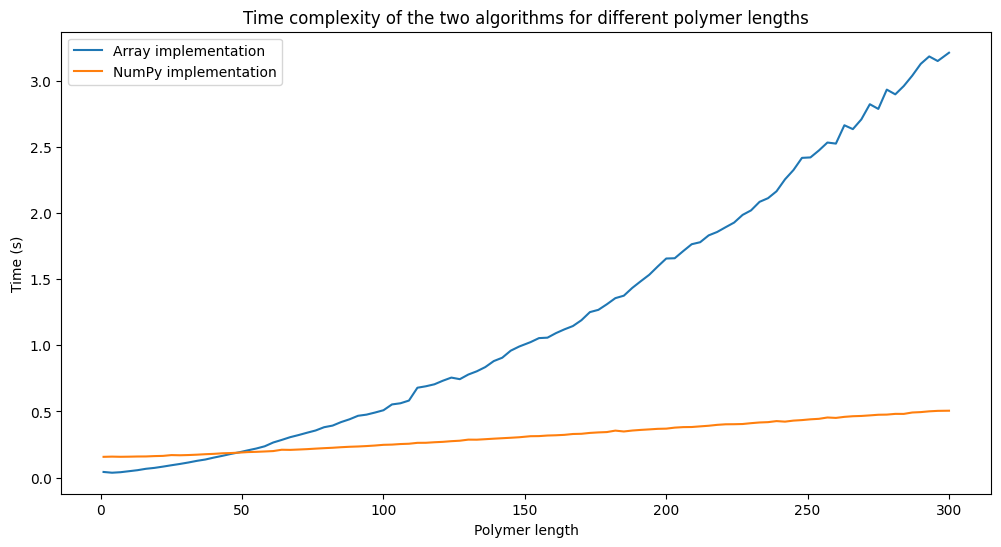

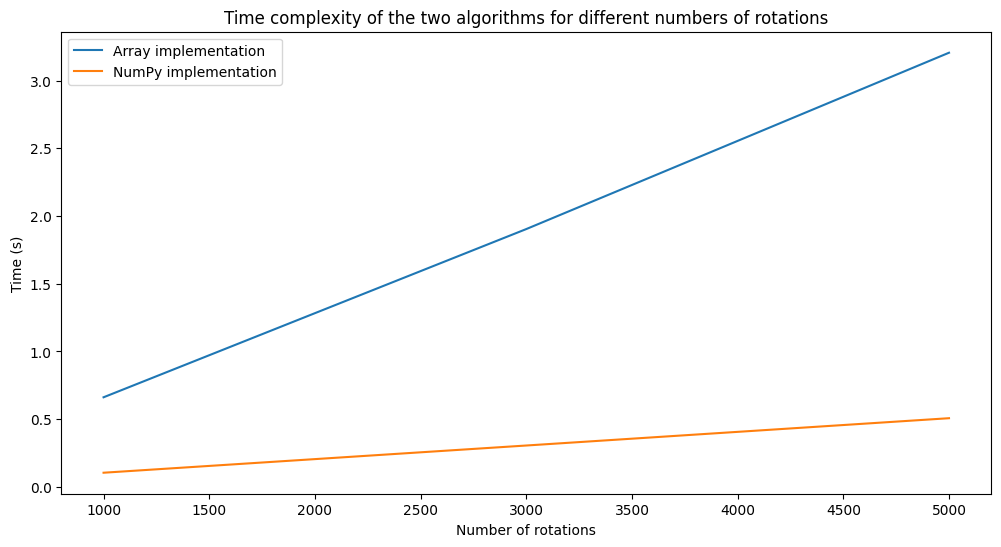

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_polymer_length, time_complexity_series_polymer_length_array, label="Array versjon")
plt.plot(time_series_polymer_length, time_complexity_series_polymer_length_np, label="NumPy versjon")
plt.xlabel("Polymer lengde")
plt.ylabel("Tid (s)")
plt.title("Kjøretid for algoritmene for ulike polymer lengder")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_series_rotations, time_complexity_series_rotations_array, label="Array versjon")
plt.plot(time_series_rotations, time_complexity_series_rotations_np, label="NumPy versjon")
plt.xlabel("Antall rotasjoner")
plt.ylabel("Tid (s)")
plt.title("Kjøretid for algoritmene for forskjellig antall rotasjoner")
plt.legend()
plt.show()

I figurene over kan en se hvordan kjøretiden blir påvirket av henholdsvis polymer lengden og antall rotasjoner. I figuren som ser på utvikling ved økende polymer lengde kan det observeres at NumPy implementasjonen har en betydelig bedre kjøretid ved lange polymerer. Det kan antas at disse har forskjellige komplekiteter, hvor Array implementasjonen har O(Nˆ2), eventuelt O(N*log(N)), mens Numpy implementasjonen ser ut til å være O(N). Dette er på grunn av at Numpy matriser, som er implementert i C, er generelt betydelig raskere enn lister som er implementert i Python, samtidig som at Numpy implementasjonen fokuserer på å gjøre kalkulasjoner med lineær algebra. I figuren som ser på endringen ved forskjellige mengder kan en observere at de begge ser ut til å ha O(N) kjøretid kompleksitet, men NumPy har fortsatt bedre trend.
NumPy metoder er som regel implementert i C, mens Lister implementeringen gjorde flere operasjoner i python. Siden C er et kompilert språk vil det ha lavere abstraksjon enn Python som på sin side er et tolket språk, som fører til at det er mer maskinnært og dermed bidra til bedre ytelse.

#### 1i)

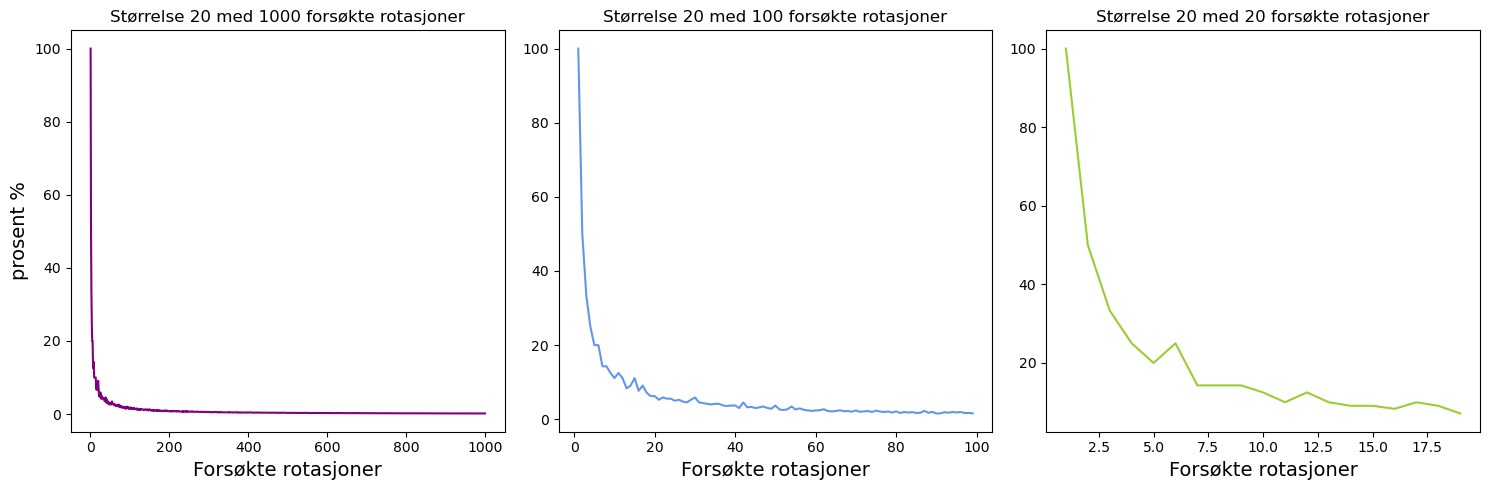

In [339]:
def plot_prosent(N: int, N_s: int) -> (list[float], list[float]):
    """
    plots the percentage of rotations based on attempted rotations
    :param N: int
    :param N_s: int
    :return: list[float]
    """
    x_arr = []
    y_arr = []
    for i in range(1, N_s):
        _, count = algorithm1_optimized(N, i)
        x_arr.append(i) #creates array from 0 -> N_s
        y_arr.append(100/count) #creates array with percentage of succsessful rotations
    return x_arr, y_arr


N = 20
N_s = 1000
x_arr, y_arr = plot_prosent(N,N_s) #plot for N_s =1000
fig, axs =plt.subplots(1,3, figsize = (15,5))
axs[0].plot(x_arr,y_arr, color = "purple")
axs[0].set_title(f"Størrelse {N} med {N_s} forsøkte rotasjoner")
axs[0].set_ylabel("prosent %", fontsize = 14)
axs[0].set_xlabel("Forsøkte rotasjoner", fontsize = 14)


N_s = 100
x_arr, y_arr = plot_prosent(N,N_s) #plots for N_s = 100
axs[1].plot(x_arr,y_arr, color = "cornflowerblue")
axs[1].set_title(f"Størrelse {N} med {N_s} forsøkte rotasjoner")
axs[1].set_xlabel("Forsøkte rotasjoner", fontsize = 14)

N_s = 20
x_arr, y_arr = plot_prosent(N,N_s) #plots for N_s = 20
axs[2].plot(x_arr,y_arr, color = "yellowgreen")
axs[2].set_title(f"Størrelse {N} med {N_s} forsøkte rotasjoner")
axs[2].set_xlabel("Forsøkte rotasjoner", fontsize = 14)
plt.tight_layout()
plt.show()




Med N_s satt til 1000 blir grafen vanskelig å tyde fordi variasjonen i all hovedsak skjer for lavere forsøkte rotasjoner. Prosenten for vellykkede rotasjoner konverger mot 0 som tydelig vises etter omtrendt 200 forsøkte rotasjoner. På de to andre grafene er N_s = 100 og N_s = 20 satt, har grafen samme form, det er en tydelig sammenheng mellom vellykkede rotasjoner og antall rotasjoner forsøkt. Denne observasjonen er ikke en overraskelse grunnet et polymer som er forsøkt rotert flere ganger vil få en mer kompleks form og vil få lavere sannsynelighet for å kunne roteres flere ganger, fordi det er større sannsynlighet for å rotere inn i seg selv blandt annet. N_s satt til en verdi mellom 20 og 100 vil være hensiktsmessig for å kunne tydelig lese og forstå verdiene

### 1j)

In [340]:

def create_V_matrix(N: int, value: float) -> list[int]:
    """
    Function creates N x N matrix with 0 across, over and under the diagonal
    :param N: int
    :return: list[int][int]
    """
    # Create an N x N matrix with 0
    matrix = np.zeros((N, N), dtype=int) 

    #sets upper triangle in V matrix to -1
    matrix[np.triu_indices(N, k=2)] = value  

    #sets lower triangle in V matrix to -1
    matrix[np.tril_indices(N, k=-2)] = value  

    return matrix



In [341]:
def calculate_polymer_energy(polymer, V):
    """
    Beregner energien til en polymer basert på en liste av monomerposisjoner og en vekselvirkningsmatrise V.

    :param polymer: List av tuples som representerer posisjonene til monomerene i polymeren.
    :param V: Numpy matrise som representerer styrken av vekselvirkningene mellom monomerene.
    :return: Energien til polymeren.
    """
    N = len(polymer)  # Antall monomerer i polymeren
    E = 0  # Initialiserer energien

    # Gå gjennom alle par av monomerer for å beregne energibidraget
    for m in range(N):
        for n in range(N):
            if n != m and n != m+1 and n != m-1:  # Sjekker at n er en gyldig nabo
                if is_nearest_neighbor(polymer[m], polymer[n]):
                    E += V[m, n]

    # Normaliser energien siden alle vekselvirkninger telles to ganger
    E = E / 2
    return E

def is_nearest_neighbor(monomer1, monomer2):
    """
    Sjekker om to monomerer er nærmeste naboer i et kvadratisk gitter.

    :param monomer1: Tuple som representerer posisjonen til det første monomeret.
    :param monomer2: Tuple som representerer posisjonen til det andre monomeret.
    :return: True hvis de er nærmeste naboer, ellers False.
    """
    # Beregner avstanden mellom monomerene
    dx = abs(monomer1[0] - monomer2[0])
    dy = abs(monomer1[1] - monomer2[1])

    # Sjekker om avstanden tilsvarer nærmeste naboer
    return (dx == 1 and dy == 0) or (dx == 0 and dy == 1)

In [372]:
# testing energy
polymerene = np.load("polymer.npz")
polymer_4_load = polymerene["polymer1"]
polymer_1000_load = polymerene["polymer2"]

V = create_V_matrix(15, -1)
print(f'Energien til polymeret med 4 forsøkte rotasjoner er: {calculate_polymer_energy(polymer_4_load, V)}')

print(f'Energien til polymeret med 1000 forsøkte rotasjoner er: {calculate_polymer_energy(polymer_1000_load, V)}')

Energien til polymeret med 4 forsøkte rotasjoner er: 0.0
Energien til polymeret med 1000 forsøkte rotasjoner er: -6.0


Resultatet for energien til de to polymerene i oppgave 1g) viser at polymeren som er forsøkt å rotere 1000 ganger har større energi hver gang med noen unntak i forhold til polymeren som er forsøkt rotert 4 gang. Denne forskjellen i energi er forventet fordi med flere forsøkte rotasjoner vil vi få flere muligheter for vekselvirkninger mellom monomerer som danner større energi. 

## Oppgave 2: Monte Carlo-simuleringer

#### 2 a)

In [343]:
def algorithm2(polymer_array: np.ndarray, Ns: int, interaction_matrix: np.ndarray, temperature: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs a Monte Carlo simulation using the Metropolis algorithm for a polymer.
    
    :param polymer_array: Initial position of the polymer as a NumPy array of shape (N, 2).
    :param Ns: Number of valid rotation attempts.
    :param interaction_matrix: Numpy matrix representing interaction strengths between monomers.
    :param temperature: Dimensionless temperature of the system.
    :return: Tuple consisting of the updated polymer array and energy array.
    """
    N = polymer_array.shape[0]
    energy_array = np.zeros(Ns)
    current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
    boltzmann_constant = 1.38e-23  # Boltzmann constant in J/K
    beta = 1 / (temperature * boltzmann_constant)  # Inverse temperature, assuming kB = 1 for simplicity
    i = 0

    while i < Ns:
        random_monomer_index = np.random.randint(N)
        rotate_clockwise = np.random.choice([True, False])
        rotated_polymer_array = rotate_polymer_np(polymer_array, polymer_array[random_monomer_index], not rotate_clockwise)

        if is_intact_polymer_np(rotated_polymer_array, N):
            current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
            new_energy = calculate_polymer_energy(rotated_polymer_array, interaction_matrix)
            delta_energy = new_energy - current_energy
            if delta_energy < 0: 
                polymer_array = rotated_polymer_array
                current_energy = new_energy
            if np.random.rand() < np.exp(-beta * delta_energy*4.0e-21):
                polymer_array = rotated_polymer_array
                current_energy = new_energy
                #print("random event, ")
            energy_array[i] = current_energy
            i += 1  # Increment i after each valid rotation attempt
                

    return polymer_array, energy_array

#### 2b)

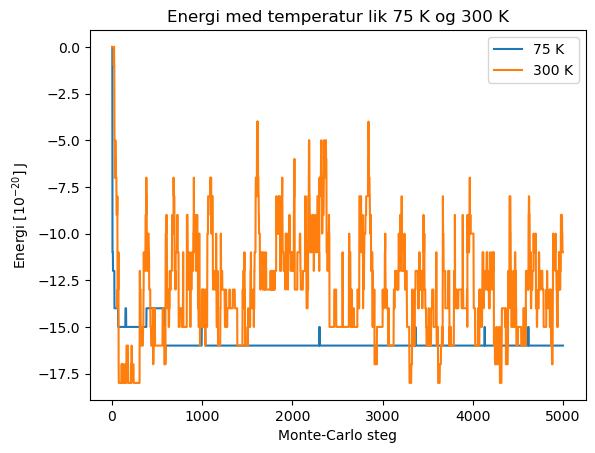

In [344]:
# plot the energy of a polymer at 75 K and 300 K

N_s = 5000
polymer_30 = create_polymer(30)
V_matrix = create_V_matrix(30, -1)
polymer_array_k, energy_array_k  = algorithm2(polymer_30, N_s, V_matrix, 75)
polymer_array_v, energy_array_v = algorithm2(polymer_30, N_s, V_matrix,300)

plt.plot(np.linspace(0,N_s,N_s),energy_array_k, label = "75 K")
plt.plot(np.linspace(0,N_s,N_s),energy_array_v, label = "300 K")
plt.title("Energi med temperatur lik 75 K og 300 K")
plt.xlabel("Monte-Carlo steg")
plt.ylabel(r'Energi [$10^{-20}$] J')
plt.legend()
plt.show()

I grafen ovenfor vises utviklingen av energinivået til i polymerer etterhvert som de blir utsatt for flere tilfeldige rotasjoner simulert av algoritme2. Energien til polymeret er plottet langs y-aksen og antall monte-carlo steg gjort av algoritme2 langs x-aksen. De to polymerene illustrert i plottet er like lange, og har ellers nesten de samme parameterene, som antall tilfeldige rotasjoner, 5000, og lik v-matrise. De skilles derimot i hvilken temperatur de har. Den blå grafen har en temperatur på 75K og den og den oransje er 300K. Videre omtales de henholdsvis som kald og varm polymer.

Fra plottet kan det observeres at energinivået til den varme polymeren er mye mindere stabilt enn det kalde polymeret, og varier gjennom hele simuleringen. Det er tydelig at snitt energien til den kalde polymeren er lavere enn den varmepolymeren. Likevell er det mulig at den varme polymeren har til tider lavere energi enn den kalde, før energien endrers med en ny rotasjon. Dette er et resultat av at den varme polymeren har høyere grunnenergi og er dermed mer volatil. Polymerene veskelsvirker med seg selv etterhvert som de brettes, og dette minker sannsynligheten for at en ny rotasjon vil føre til en lavere energinivå for polymeret. Dette betegnes for et lokalt energiminima og polymeren vil kun flytte seg ut av dette ved tilfeldige rotasjoner bestemt kun av sannsynlighet. I den blå grafen kan dette sees som små hopp i energinivået før det kalde polymeret, som oftest, brettes tilbake inn i det lokale energiminimaet. Den varme polymeren derimot har mer energi og har dermed mye høyere sannsynlighet for å hoppe helt ut av lokale energiminima og rotere inn i et nytt minima. Dette vises i grafen som den kaotiske bevegelsen av energinivået til den varme polymeren.

### 2c)

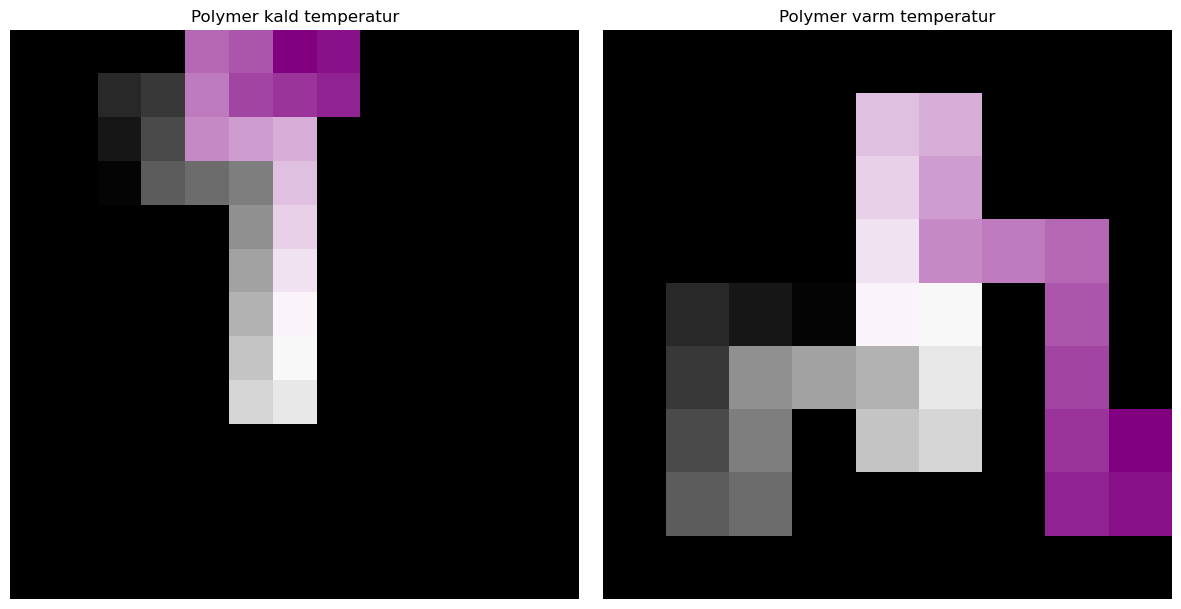

In [345]:
#Funksjonen display_polymer_side_by_side er definert i oppgave 1d)
display_polymer_side_by_side(polymer_array_k, polymer_array_v, "Polymer kald temperatur", "Polymer varm temperatur")

Illustrasjonene over viser sluttposisjonen til den kalde polymeren til venstre og den varme polymeren til høyre. Som diskutert i forrige oppgave vil den varme polymeren som regel, ikke alltid,  ha høyere sluttenergi enn den kalde polymeren. Ettersom energien avhenger av vekselsvirkning mellom monomerer vil dette tilsi at den varme polymeren har som oftest større utstrekning enn den kalde.

### 2d)

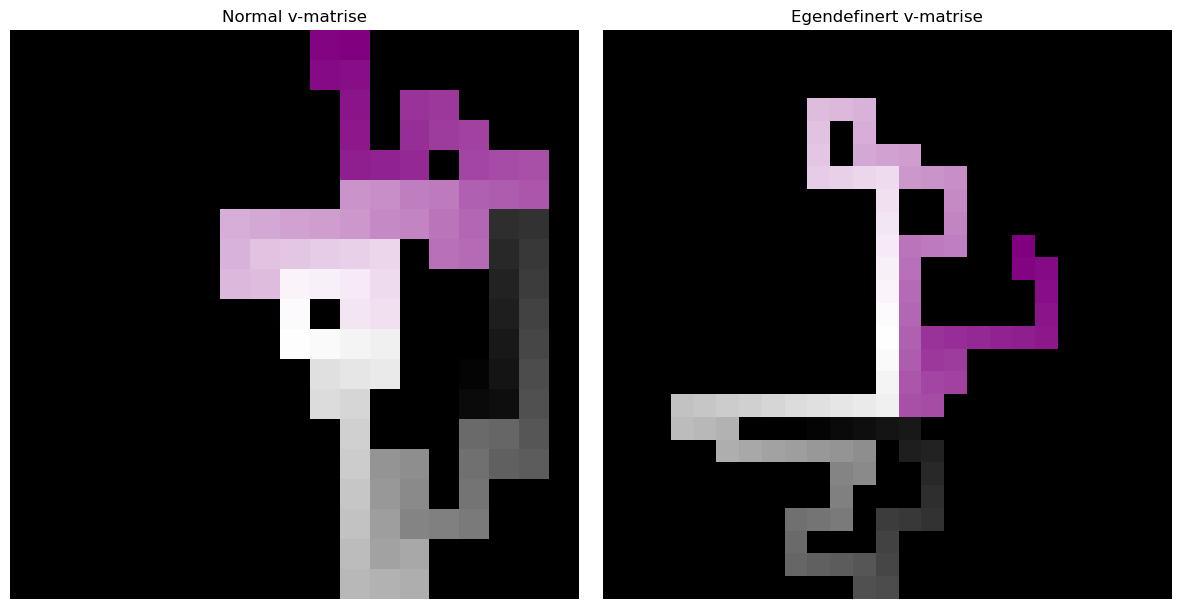

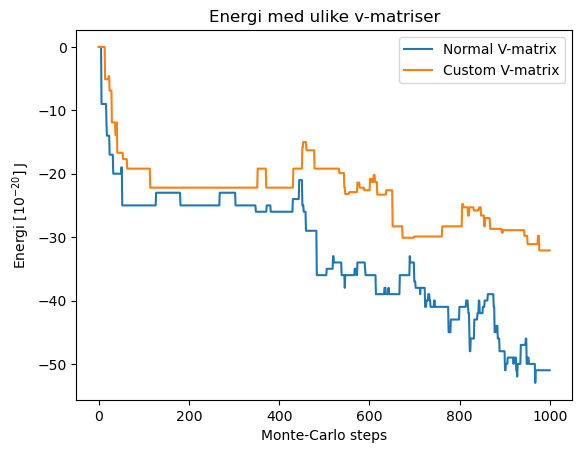

In [346]:
def create_custom_v_matrix(n: [int], value: [float]) -> list[int]:
    """
    Function to create a custom symmetrical V matrix where the elements inside the
    matrix increase by one for every step away rom the axis.
    """
    # Create an empty matrix
    matrix = np.zeros((n, n), dtype=int)

    # Create indices for the upper triangle
    rows, cols = np.triu_indices(n, k=6)

    # Fill the upper triangle with values increasing by one for each number away from the main diagonal
    matrix[rows, cols] = matrix[cols, rows] = np.abs(rows - cols) + 1

    return matrix*-value 

#Comparison of polymer using standard V-matrix vs the custom matrix
N_s = 1000

normal_polymer, normal_energy_array = algorithm2(create_polymer(100), N_s, create_V_matrix(100, -1), 300)
custom_polymer, custom_energy_array = algorithm2(create_polymer(100), N_s, create_custom_v_matrix(100, 0.05), 300)

display_polymer_side_by_side(normal_polymer, custom_polymer, "Normal v-matrise", "Egendefinert v-matrise")

plt.plot(np.linspace(0,N_s,N_s),normal_energy_array, label = "Normal V-matrix")
plt.plot(np.linspace(0,N_s,N_s),custom_energy_array, label = "Custom V-matrix")
plt.title("Energi med ulike v-matriser")
plt.xlabel("Monte-Carlo steps")
plt.ylabel(r'Energi [$10^{-20}$] J')
plt.legend()
plt.show()

Create_V_matrix lager en standard v-matrise, av størrelse n, hvor alle ikke-nullelementene er lik minus en. Funksjonen create_custom_v_matrix generer en symmetrisk v-matrise hvor elementene inni grafen, nærmest diagonalen, er svært lave verdier og så stiger verdien av elemntene proposjonalt med avstanden til diagonalen. Parameter 1 er størrelsen til v-matrisen den skal generere, som må være lik størrelsen av polymeren. Den andre parameteren er kun en integer som skalerer styrken på custom matrisen. Uten denne skalerverdien vil sluttpolymeren likevel se lik ut ettersom verdien skalerer hele matrisen, men energien til den egendefinerte polymeren hadde vært ekstremt lav. For å vise en mer intersant sammenlikning i energigrafene i plottet "Energi med ulike v-matriser, benyttes denne.

Observasjon av sluttposisjonen til polymerene viser tydelig forskjell i oppbyggningen av polymerene. Alle parameterene er like, annet enn v-matrisene. Med standard v-matrise er kraften til vekselsvirkningen mellom alle monomerer lik, det vil si at det er lik tiltrekning mellom to monomerer som er nesten ved siden hverandre og to monomerer som er langt fra hverandre. Dette fører til at polymeren bretter seg slik at flest antall monomerer har flest antall naboer. 
Derimot vises det tydelig i andre illustrasjon at polymeren med custom v-matrise ikke følger denne oppbyggningen. Denne alternative oppførselen forkommer av custom v-matrisen sine endrende elementer. Når elementene stiger i takt med avstanden fra diagonalen gjør det at vekselsvirkningskraften mellom monomerer endres avhengig av distansen mellom de. Det gjør at 2 monomerer som er langt fra hverandre kan gi lavere energi en 5 som ligger etter hverandre i polymeren. Dette øker sannsynligheten for at store løkker kan oppstå, ofte flere store løkker i en polymer.

#### 2e)

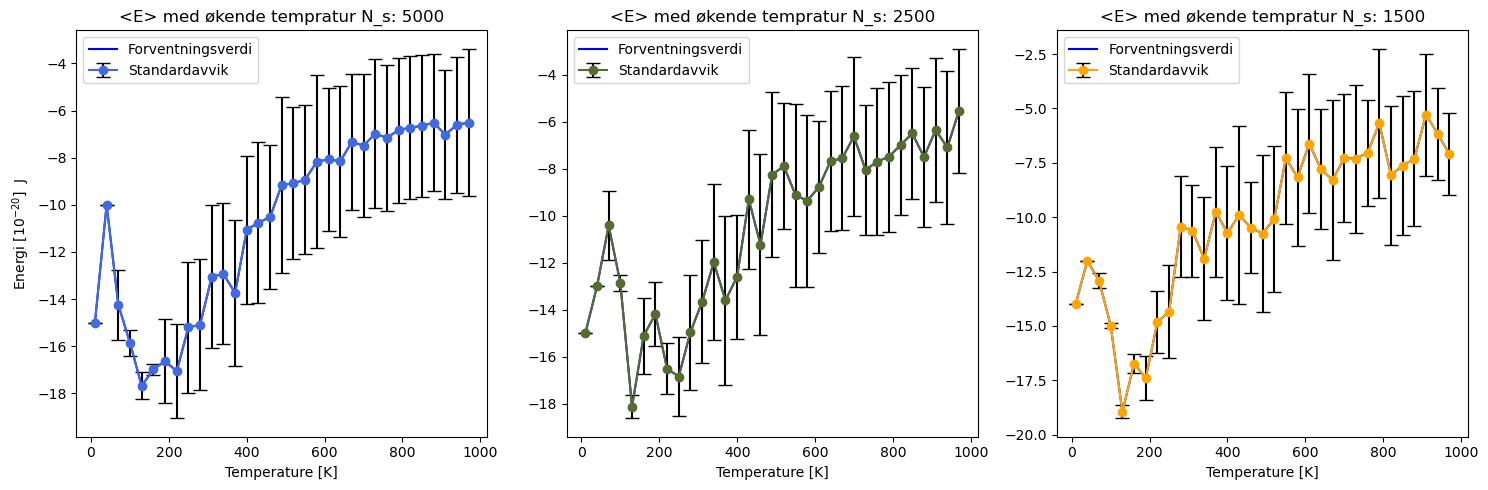

In [347]:
def excpected_energy(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    """
    temprature = np.arange(10,1000, 30) #creates array with temprature
    polymer1 = create_polymer(N) #creates polymer with length N
    expected = []
    deviation = []
    for i in temprature:
        _, energy_array = algorithm2(polymer1, N_s, V_matrix,i) 
        energy_array = energy_array[1000:] #exlude first 1000 simulations
        expected.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
    return expected, deviation, temprature
N = 30
N_s = 5000
fig, axs = plt.subplots(1,3, figsize = (15,5))
expected, deviation, temprature = excpected_energy(N, N_s, create_V_matrix(N,-1))
axs[0].plot(temprature,expected, label= "Forventningsverdi", color = "b")
axs[0].errorbar(temprature,expected ,  yerr= (deviation), fmt='-o', color = "royalblue", ecolor = "black",capsize=5, label='Standardavvik')
axs[0].set_title(f"<E> med økende tempratur N_s: {N_s}")
axs[0].set_xlabel("Temperature [K]")
axs[0].set_ylabel(r'Energi [$10^{-20}$]  J')
axs[0].legend()

N_s = 2500
expected, deviation, temprature = excpected_energy(N, N_s, create_V_matrix(N,-1))
axs[1].plot(temprature,expected, label= "Forventningsverdi", color = "b")
axs[1].errorbar(temprature,expected ,  yerr= (deviation), fmt='-o', color = "darkolivegreen", ecolor = "black",capsize=5, label='Standardavvik')
axs[1].set_title(f"<E> med økende tempratur N_s: {N_s}")
axs[1].set_xlabel("Temperature [K]")
axs[1].legend()

N_s = 1500
expected, deviation, temprature = excpected_energy(N, N_s, create_V_matrix(N,-1))
axs[2].plot(temprature,expected, label= "Forventningsverdi", color = "b")
axs[2].errorbar(temprature,expected ,  yerr= (deviation), fmt='-o', color = "orange", ecolor = "black",capsize=5, label='Standardavvik')
axs[2].set_title(f"<E> med økende tempratur N_s: {N_s}")
axs[2].set_xlabel("Temperature [K]")
axs[2].legend()

plt.tight_layout()
plt.show()

Plottene viser en klar sammenheng mellom energi og tempratur, forventingsverdien til polymeren øker i verdi sammen med tempraturen. Standardavviket er noe varierende men øker gradvis med tempraturen. Grafene viser en jevn utvikling både på forventingsverdi og standardavvik med endring på N_s, standardavviket øker med tempraturen, mens energien minker som forventet og diskutert i 2b. Forskjellen som skiller seg mellom de uliker verdiene på N_s er varians i forventingsverdien. Økningen er mer tydeligere med høyere N_s, som en tydelig kan se i de ulike plottene

#### 2f)

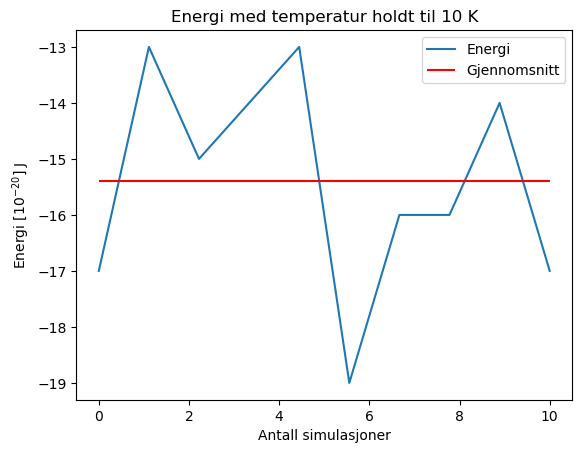

In [348]:
# plot the energy of a polymer at 10 K

N_s = 5000

def constant_temprature_sim(N, N_s, V_matrix, temprature):
    polymer1 = create_polymer(N)
    expected = []
    for i in range(10):
        _, energy = algorithm2(polymer1,N_s, V_matrix, temprature)
        energy = energy[1000:]
        expected.append(np.mean(energy))
    return expected
energies_at_10 = constant_temprature_sim(N, N_s, create_V_matrix(N, -1), 130)
plt.plot(np.linspace(0,10,10),energies_at_10, label = "Energi")
plt.hlines(np.mean(energies_at_10),0,10, color = "r", label = "Gjennomsnitt")
plt.title("Energi med temperatur holdt til 130 K")
plt.xlabel("Antall simulasjoner")
plt.ylabel(r'Energi [$10^{-20}$] J')
plt.legend()
plt.show()

I plottet ser en 10 simuleringer av energien samt et empirisk gjennomsnitt av verdien. Ifra oppgave 2e er det observert at standaravviket øker med tempraturen, derav vil 10 simuleringen av disse verdiene, og bruk av empirisk gjennomsnitt, bli mer nøyaktig og nærmere sann verdi for energien enn  bare en simulering. I plottet kan en observere små endringer for hver simulasjon, noe som er forventet gitt tilfeldigheten i simuleringen. Temperaturen 130 K ble valgt grunnet observasjon av lavt standardavvik og lav forventet energi som observert i oppgave 2e

### 2g)

In [349]:
def algorithm2_with_d(polymer_array: np.ndarray, Ns: int, interaction_matrix: np.ndarray, temperature: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs a Monte Carlo simulation using the Metropolis algorithm for a polymer.
    
    :param polymer_array: Initial position of the polymer as a NumPy array of shape (N, 2).
    :param Ns: Number of valid rotation attempts.
    :param interaction_matrix: Numpy matrix representing interaction strengths between monomers.
    :param temperature: Dimensionless temperature of the system.
    :return: Tuple consisting of the updated polymer array and energy array and size array.
    """
    N = polymer_array.shape[0]
    energy_array = np.zeros(Ns)
    size_array = np.zeros(Ns)
    current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
    boltzmann_constant = 1.38e-23  # Boltzmann constant in J/K
    beta = 1 / (temperature * boltzmann_constant)  # Inverse temperature, assuming kB = 1 for simplicity
    i = 0

    while i < Ns:
        random_monomer_index = np.random.randint(N)
        rotate_clockwise = np.random.choice([True, False])
        rotated_polymer_array = rotate_polymer_np(polymer_array, polymer_array[random_monomer_index], not rotate_clockwise)

        if is_intact_polymer_np(rotated_polymer_array, N):
            current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
            new_energy = calculate_polymer_energy(rotated_polymer_array, interaction_matrix)
            delta_energy = new_energy - current_energy
            if delta_energy < 0: 
                polymer_array = rotated_polymer_array
                current_energy = new_energy
            if np.random.rand() < np.exp(-beta * delta_energy*4.0e-21):
                polymer_array = rotated_polymer_array
                current_energy = new_energy

            #Calculating the pairwise distances between all monomers
            pairwise_distances = np.linalg.norm(polymer_array - polymer_array[:, np.newaxis], axis=-1)
            #Excluding the diagonal (distance between a monomer and itself)
            np.fill_diagonal(pairwise_distances, 0)
            #Finding the maximum distance
            maximum_distance = np.max(pairwise_distances)

            energy_array[i] = current_energy
            size_array[i] = maximum_distance

            i += 1  # Increment i after each valid rotation attempt
                

    return polymer_array, energy_array, size_array

In [350]:
def create_random_v_matrix(n: [int], lowerbound: [float], upperbound: [float]) -> list[int]:
    """
    Function to create a symmetrical v-matrix where the elements in the matrix are randomized between
    an upper- and lower-bound.
    :param n: int
    :param lowerbound: float
    :param upperbound: float
    :return: list[int][int]
    """
    # Create an empty matrix
    matrix = np.zeros((n, n), dtype=float)

    # Create indices for the upper triangle
    rows, cols = np.triu_indices(n, k=2)

    #Randomizing the elements within the triangle within the specified bounds
    random_values = np.random.uniform(lowerbound, upperbound, len(rows))
    matrix[rows, cols] = matrix[cols, rows] = random_values

    return matrix*-1

    
def excpected_energy_and_size(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation, as well as its size (diameter).
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    :return: list[float], list[float], list[float], list[float]
    """

    temprature = np.arange(10,1000, 30) #creates array with temprature
    polymer1 = create_polymer(N) #creates polymer with length N
    excpected_energy = []
    excpected_size = []
    deviation = []


    #For-loop that iterates through each randomized polymer for each temperature
    for i in temprature:
        polymer_array, energy_array, size_array = algorithm2_with_d(polymer1, N_s, V_matrix,i) 
        energy_array=energy_array[1000:] #exlude first 1000 simulations
        size_array = size_array[1000:]
        excpected_energy.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
        excpected_size.append(np.mean(size_array))

    return excpected_energy, deviation, temprature, excpected_size



In [351]:
#create matrix with values -6.0e-21 to -4.0e-21 at random
random_matrix = create_random_v_matrix(N,1.5,0.5)

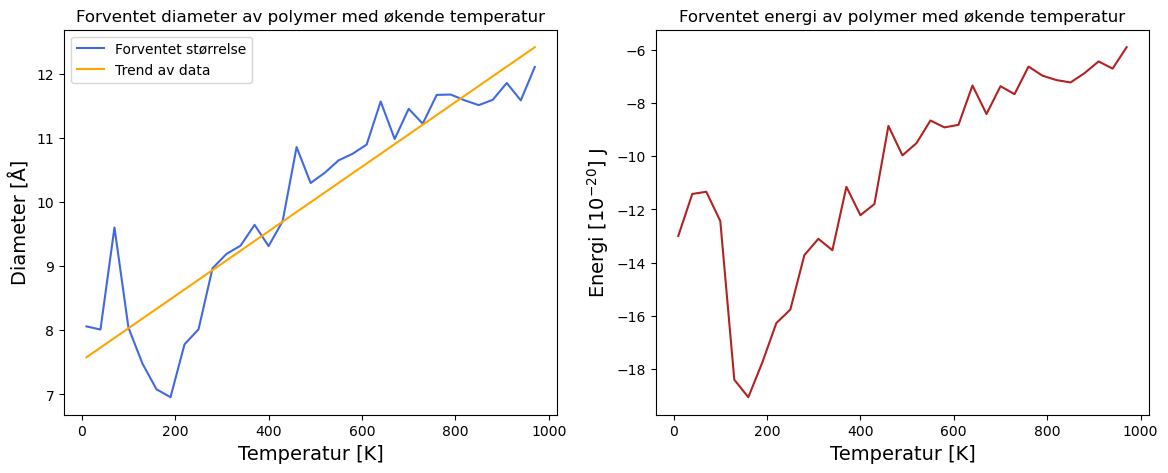

In [352]:
# plot the energy and size of a polymer

N = 30
N_s = 5000

time_start = time.time()
expected, deviation, temperature, size = excpected_energy_and_size(N, N_s, random_matrix)
time_end = time.time()

elapsed_time = time_end - time_start
minutes = elapsed_time//60
seconds = elapsed_time - minutes * 60

time_end_global = time.time()
elapsed_time_global = time_end_global - time_start_global
minutes_global = elapsed_time_global//60
seconds_global = elapsed_time_global - minutes_global * 60

correlation_matrix = np.corrcoef(size, expected)
correlation_coefficient = correlation_matrix[0, 1]
coefficients = np.polyfit(temperature, size, deg=1)
y_pred = np.polyval(coefficients, temperature)


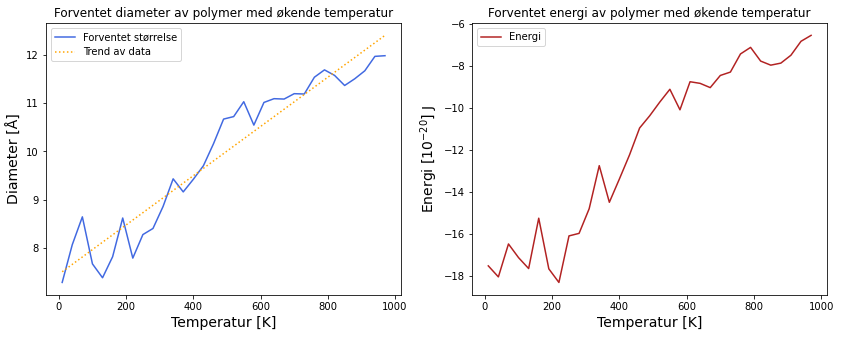

Kjøretiden av simuleringen av diameter og energi: 5m 26.0s
Korrelasjonskoeffesienten mellom forventningsverdiene for diameter og energi: 0.98


In [111]:
fig, axs = plt.subplots(1,2, figsize = (14,5))
#plot diameter and energy side by side to show correlation
axs[0].plot(temprature, size, label= "Forventet størrelse", color = "royalblue")
axs[0].set_title("Forventet diameter av polymer med økende temperatur")
axs[0].set_xlabel("Temperatur [K]", fontsize = 14)
axs[0].set_ylabel("Diameter [Å]", fontsize = 14)
axs[0].plot(temprature, y_pred, linestyle="dotted", label= "Trend av data", color = "orange")
axs[0].legend()

axs[1].plot(temprature, expected, label= "Energi", color = "firebrick")
axs[1].set_title("Forventet energi av polymer med økende temperatur")
axs[1].set_xlabel("Temperatur [K]", fontsize = 14)
axs[1].set_ylabel(r'Energi [$10^{-20}$] J', fontsize = 14)
axs[1].legend()

plt.show()

print(f'Kjøretiden av simuleringen av diameter og energi: {int(minutes)}m {np.round(seconds, 1)}s')
print(f'Total kjøretiden for hele programet: {int(minutes_global)}m {np.round(seconds_global, 1)}s')
print(f'Korrelasjonskoeffesienten mellom forventningsverdiene for diameter og energi: {np.round(correlation_coefficient, 2)}')

Både diameteren og energien til polymeret blir registrert for hvert steg, gjennom alle simulasjonene, for alle temperaturer simulasjonene blir gjort. Deretter benyttes np.mean funksjonen for å finne den empiriske forventningsverdien av hver. Deretter plottes datasettene i hver sin figur. For å fremheve trenden i dataen for diameteren av polymerene, < d >< T >, gjøres det lineær regresjon av datapunktene og den resulterende funksjonen plottes sammen med datapunktene. Slik kan det tydelig sees en stigende trend i forventningsverdien av diameteren til polymeret når temperaturen stiger.

Sammenliknes figurene for forventet diameter og forventet energi kan det observeres en tydelig korrelasjon mellom dem. Regnes ut korrelasjonskoeffisienten mellom datasettene, som gjort over, kan det observeres at den er større enn 0.85, noe som indikerer sterk lineær sammenheng. 

Høyere temperaturer fører til at forventningsverdien av energinivået til polymeren er høyere. Ettersom energinivået til polymeret avhenger direkte av vekselvirkning mellom monomerene i polymeret betyr dette at det er færre totale monomerer som vekselsvirker. Basert på at færre monomerer er i kontakt med hverandre må polymeret oppta større utstrekning i rommet, ergo polymeret har større diameter.

### 2h)

In [353]:
def expected_energy_and_size_decreasing(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation, as well as its size (diameter).
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    :return: list[float], list[float], list[float], list[float]
    """

    temperature = np.arange(10, 1000, 30)  # Creates array with temperature
    polymer1 = create_polymer(N)  # Presumably creates a polymer with length N
    expected_energy = []
    expected_size = []
    deviation = []

    # Reverse the temperature array to start from the highest temperature
    temperature_reversed = temperature[::-1]

    # For-loop that iterates through each randomized polymer for each temperature, starting from the highest
    for i in range(len(temperature_reversed)):
        polymer_array, energy_array, size_array = algorithm2_with_d(polymer1, N_s, V_matrix, temperature_reversed[i])
        energy_array = energy_array[1000:]  # Exclude first 1000 simulations
        size_array = size_array[1000:]
        expected_energy.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
        expected_size.append(np.mean(size_array))
        polymer1 = polymer_array

    return expected_energy, deviation, temperature_reversed, expected_size

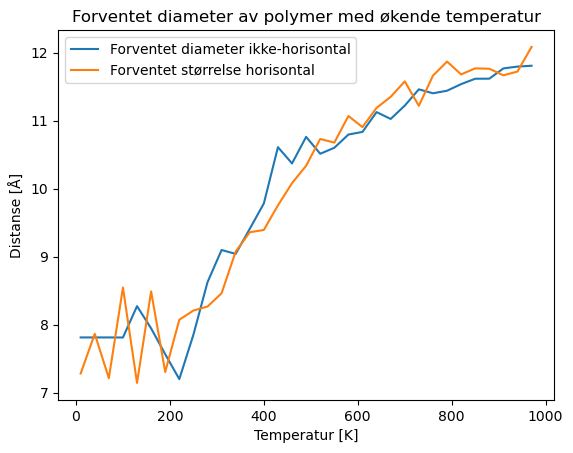

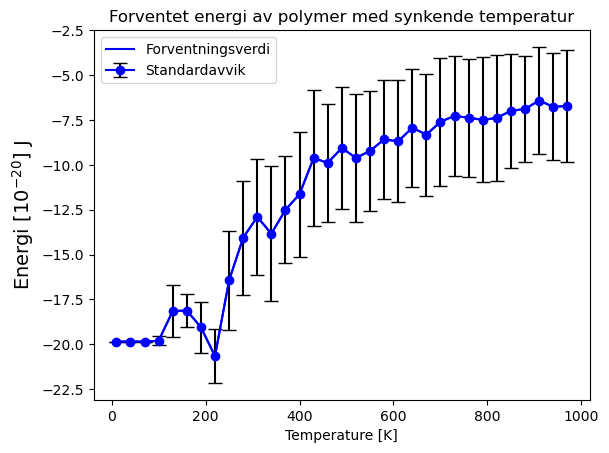

In [354]:
# plot the energy and size of a polymer with decreasing temperature
# NB we chose to not flip the x-axis, so the temperature increases from left to right as usual for display purposes

N = 30
N_s = 5000
expected_energy_decreasing, deviation_decreasing, temperature_reversed, size_decreasing = expected_energy_and_size_decreasing(N, N_s, random_matrix)
expected_energy_horizontal, deviation_horizontal, temperature_horizontal, size_horizontal = excpected_energy_and_size(N, N_s, random_matrix)

time_end_global = time.time()
elapsed_time_global = time_end_global - time_start_global
minutes_global = elapsed_time_global//60
seconds_global = elapsed_time_global - minutes_global * 60

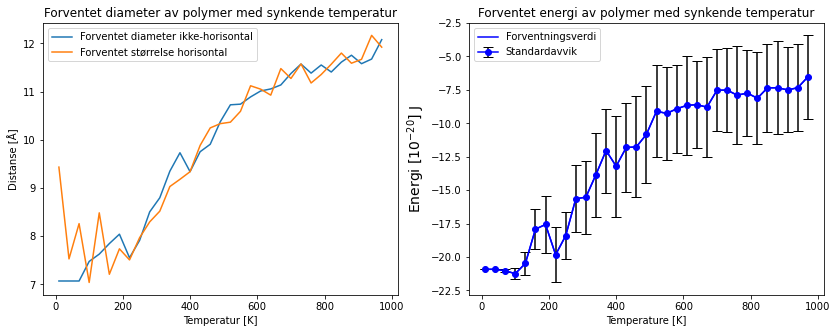

In [112]:
fig, axs = plt.subplots(1,2, figsize = (14,5))
#plot diameter and energy side by side to show correlation
axs[0].plot(temperature_reversed, size_decreasing, label= "Forventet diameter ikke-horisontal")
axs[0].plot(temperature_horizontal, size_horizontal, label= "Forventet størrelse horisontal")
axs[0].set_title("Forventet diameter av polymer med synkende temperatur")
axs[0].set_xlabel("Temperatur [K]")
axs[0].set_ylabel("Distanse [Å]")
axs[0].legend()

axs[1].plot(temperature_reversed,expected_energy_decreasing, label= "Forventningsverdi", color = "b")
axs[1].errorbar(temperature_reversed,expected_energy_decreasing, yerr= (deviation_decreasing), fmt='-o', color = "b", ecolor = "black",capsize=5, label='Standardavvik')
axs[1].set_title("Forventet energi av polymer med synkende temperatur")
axs[1].set_xlabel("Temperature [K]")
axs[1].set_ylabel(r'Energi [$10^{-20}$] J', fontsize = 14)
axs[1].legend()

plt.show()

print(f'Total kjøretid: {int(minutes_global)}m {np.round(seconds_global, 1)}s')


Måleseriene illustrert ovenfor er tilsynelatende svært lik måleserien gjort i oppgave 2g, men det eksisterer noen kritiske forskjeller mellem dem. Den benytter samme temperaturverdier som forrige oppgave men den iterer fra høyest til lavest. Mest kritisk derimot er at den ikke tilbakestiller polymeren mellom hver temperatur. Det betyr at denne prosessen beskriver den fysiske prosessen av nedkjølingen av en polymer.

Forskjellen mellom disse måleserien har reelle effekter som påvirker hvilken metode som er best egnet for å se på både lav- og høytemperaturoppførsel til polymerer. Det er etablert at ved høyere temperaturer har polynomer også høyere energi. Likevel ønsker polynomet å være i det lavest energitilstanden mulig. Dette skaper konflikt når temperaturen og dermed energien øker og polynomet prøver å minke energinivået. Dette er ettersom polymeret ønsker å være i lokale minima og ved økning av temperaturen må polymeren gjennom tilfeldige rotasjoner øke energien sin nok til å nå neste lokale minimum. Dette er grunnen til den volatile bevegelsen av energinivået til polymeren i oppgave 2b. Metoden i 2h er mindere utsatt for den kaotiske bevegelsen av polymerer ved høyere temperaturer. Ved nedkjølning er det mye høyere sannsynlighet for at polymeret kan hoppe ned i energinivå uten å være avhengig av tilfeldig rotasjoner av polymeret. Dermed er de simulerte verdiene hentet fra 2h nærmere rettet verdiene observert i virkeligheten, ergo den andre metoden er best egnet for å se på både lav- og høytemperaturoppførsel til polymerer.

##### Konklusjon

Gjennom denne rapporten har det blitt sett nærmere på data simuleringer innenfor polymerfysikk. Det ble tatt for seg numerisk framstilling av polymerer, samt forenklet tilnærming til deres miljø og vekselvirkninger. 

Det ble sett nærmere på Monte-Carlo metoder for å utføre simuleringer av polymerer og deres vekselvirkninger under diverse forhold, det ble sett ekstra nøye på de mekaniske egenskapene ved varierende lengde og temperatur. Gjennom flere simuleringer kunne en se sammenheng mellom egenskapene til polymerer og temperatur. Det var spesiellt tydelig at under lavere temperaturer kunne en forvente lavere energi for en polymer og at energien i en polymer er positivt korrelert med temperaturen.